The code in this notebook is adapted from Lab4 from the Introduction to Robotics course which can be found here https://irom-lab.princeton.edu/intro-to-robotics/

In [2]:
from RRT import RRT
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [78]:
width = 1.51
height = 2.5

obstacles = [(np.array([0.73, 0.76]), 0.5), (np.array([1.27, 1.98]), 0.5), (np.array([0.26, 1.7]), 0.5)]
goal = (np.array([0.5, 2.3]), 0.2)

origin = np.array((0.755, 0.05))

my_rrt = RRT(origin, width, height, circular_obstacles=obstacles
                        ,rectangular_obstacles=None)
vertices, parents = my_rrt.plan(2000)

index = my_rrt.nearest_vertex(goal[0], vertices)

if np.linalg.norm(vertices[index, :] - goal[0]) < 0.25:
    print('Path found!')
    path_verts = my_rrt.backtrack(index, parents)
else:
    print('No path found!')
    path_verts = []

Path found!


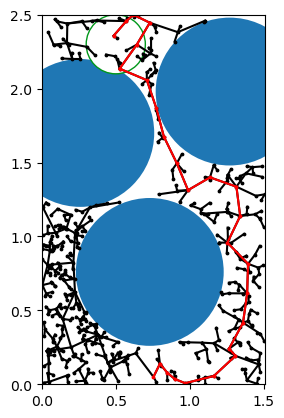

In [79]:
fig, ax = plt.subplots()

ax.set_xlim([0, width])
ax.set_ylim([0, height])
ax.set_aspect('equal')

for i in range(len(parents)):
    if parents[i] < 0:
        continue
    plt.plot([vertices[i, 0], vertices[parents[i], 0]], 
             [vertices[i, 1], vertices[parents[i], 1]], c='k')

for i in path_verts:
    if parents[i] < 0:
        continue
    plt.plot([vertices[i, 0], vertices[parents[i], 0]], 
             [vertices[i, 1], vertices[parents[i], 1]], c='r')    

for o in obstacles:
    ax.add_artist(plt.Circle(tuple(o[0]), o[1]))
    
ax.add_artist(plt.Circle(tuple(goal[0]), goal[1], ec=(0.004, 0.596, 0.105), fc=(1, 1, 1)))

plt.scatter([2.5], [3.5], zorder=3, c=np.array([[0.004, 0.596, 0.105]]), s=3)
plt.scatter(vertices[path_verts, 0], vertices[path_verts, 1], c=np.array([[1, 0, 0]]), s=3, zorder=2)
plt.scatter(vertices[1:, 0], vertices[1:, 1], c=np.array([[0, 0, 0]]), s=3)


In [80]:
def seg_to_setpoints(start_conf: np.ndarray, end_conf: np.ndarray) -> np.ndarray:
    # This function takes in the RRT trajectory and outputs a sequence of setpoints for the drone to follow. 
    
    dist = np.linalg.norm(start_conf - end_conf)
    num_samples = int(100 * dist)
    
    return end_conf.reshape((1, 2))

traj = origin.reshape(1, 2)
for i in range(len(path_verts) - 1):
    traj = np.concatenate((traj, seg_to_setpoints(vertices[path_verts[i]], vertices[path_verts[i + 1]])))

In [72]:
 # Code adapted from: https://github.com/bitcraze/crazyflie-lib-python/blob/master/examples/autonomousSequence.py

import time
# CrazyFlie imports: 
import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.syncLogger import SyncLogger

## Some helper functions: 
## -----------------------------------------------------------------------------------------

# Determine initial position: 
def wait_for_position_estimator(scf):
    print('Waiting for estimator to find position...')

    log_config = LogConfig(name='Kalman Variance', period_in_ms=500)
    log_config.add_variable('kalman.varPX', 'float')
    log_config.add_variable('kalman.varPY', 'float')
    log_config.add_variable('kalman.varPZ', 'float')

    var_y_history = [1000] * 10
    var_x_history = [1000] * 10
    var_z_history = [1000] * 10

    threshold = 0.001
    with SyncLogger(scf, log_config) as logger:
        for log_entry in logger:
            data = log_entry[1]

            var_x_history.append(data['kalman.varPX'])
            var_x_history.pop(0)
            var_y_history.append(data['kalman.varPY'])
            var_y_history.pop(0)
            var_z_history.append(data['kalman.varPZ'])
            var_z_history.pop(0)

            min_x = min(var_x_history)
            max_x = max(var_x_history)
            min_y = min(var_y_history)
            max_y = max(var_y_history)
            min_z = min(var_z_history)
            max_z = max(var_z_history)

            print("{} {} {}".
                format(max_x - min_x, max_y - min_y, max_z - min_z))

            if (max_x - min_x) < threshold and (
                    max_y - min_y) < threshold and (
                    max_z - min_z) < threshold:
                break

# Initialize controller: 
def set_PID_controller(cf):
    # Set the PID Controller:
    print('Initializing PID Controller')
    #cf.param.set_value('stabilizer.controller', '1')
    cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    cf.param.set_value('kalman.resetEstimation', '0')
    
    wait_for_position_estimator(cf)
    time.sleep(0.1)    
    return

# Ascend and hover: 
def ascend_and_hover(cf):
    # Ascend:
    for y in range(20):
        cf.commander.send_hover_setpoint(0, 0, 0, y / 63)
        time.sleep(0.1)
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.3)
        time.sleep(0.1)
    return

# Follow the setpoint sequence trajectory:
def run_sequence(scf, sequence, setpoint_delay):
    cf = scf.cf
    for position in sequence:
        print(f'Setting position {(position[0], (position[1]))}')
        for i in range(setpoint_delay):
            cf.commander.send_position_setpoint(position[0],
                                                (position[1]),
                                                0.3,
                                                0.0)
            time.sleep(0.1)
    
# Hover, descend, and stop all motion:
def hover_and_descend(cf):
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.3)
        time.sleep(0.1)
    # Descend:
    for y in range(10):
        cf.commander.send_hover_setpoint(0, 0, 0, (10 - y) / 33)
        time.sleep(0.1)
    # Stop all motion:
    for i in range(10):
        cf.commander.send_stop_setpoint()
        time.sleep(0.1)
    return
## -----------------------------------------------------------------------------------------

def run_setpoint_trajectory(group_number, sequence):  
    # This is the main function to enable the drone to follow the trajectory. 
    
    # User inputs:
    #
    # - group_number: (int) the number corresponding to the drone radio settings. 
    #
    # - sequence: a series of point locations (float) defined as a numpy array, with each row in the following format: 
    #     [x(meters), y(meters)]
    #   Note: the input should be given in drone coordinates (where positive x is forward, and positive y is to the left).
    # Example: 
    # sequence = [
    #     [[ 0.          0.        ]
    #      [0.18134891  0.08433607]]
    # 

    # Outputs: 
    # None. 
    
    setpoint_delay = 8 # (int) Time to give the controller to reach next setpoint; in multiples of 0.1 s
    
    # Set the URI the Crazyflie will connect to
    uri = f'radio://0/{group_number}/2M'
    
    # Initialize all the CrazyFlie drivers:
    cflib.crtp.init_drivers(enable_debug_driver=False)

    # Sync to the CrazyFlie: 
    with SyncCrazyflie(uri, cf=Crazyflie(rw_cache='./cache')) as scf:
        # Get the Crazyflie class instance:
        cf = scf.cf

        # Initialize and ascend:
        set_PID_controller(cf)
        ascend_and_hover(cf)
        # Run the waypoint sequence:
        run_sequence(scf, sequence, setpoint_delay)
        # Descend and stop all motion: 
        hover_and_descend(cf)
            
    print('Done!') 
    return

In [81]:
# restructure trajectory to be in right format for drone
traj = traj - origin

'''
# get distances for the crazyflie to travel
updated_traj = np.array([traj[0,:]])
for i in range(len(traj) - 1):
    updated_traj = np.concatenate((updated_traj, [[(traj[i,0] - traj[i+1,0]),(traj[i+1,1] - traj[i,1])]]))

# 1. switch x and y coordinates
updated_traj_switched = np.zeros((len(updated_traj),2))
updated_traj_switched[:,] = updated_traj[:,[1, 0]]
'''

'\n# get distances for the crazyflie to travel\nupdated_traj = np.array([traj[0,:]])\nfor i in range(len(traj) - 1):\n    updated_traj = np.concatenate((updated_traj, [[(traj[i,0] - traj[i+1,0]),(traj[i+1,1] - traj[i,1])]]))\n\n# 1. switch x and y coordinates\nupdated_traj_switched = np.zeros((len(updated_traj),2))\nupdated_traj_switched[:,] = updated_traj[:,[1, 0]]\n'

In [82]:
updated_traj_switched = np.zeros((len(traj),2))
updated_traj_switched[:,] = traj[:,[1, 0]]

In [83]:
updated_traj_switched

array([[ 0.        ,  0.        ],
       [ 0.08889532,  0.04383327],
       [ 0.02889235,  0.09260033],
       [-0.01450144,  0.1445025 ],
       [-0.04271497,  0.214489  ],
       [ 0.00605927,  0.40845053],
       [ 0.14245005,  0.55472956],
       [ 0.19057927,  0.51127048],
       [ 0.3667357 ,  0.60597482],
       [ 0.56482029,  0.63358814],
       [ 0.76472476,  0.63976921],
       [ 0.90785501,  0.50007766],
       [ 1.088208  ,  0.58652301],
       [ 1.28658334,  0.56108236],
       [ 1.34937701,  0.38239757],
       [ 1.26300731,  0.2337868 ],
       [ 1.44453452,  0.15820341],
       [ 1.62435761,  0.07066109],
       [ 1.81761863,  0.01918124],
       [ 2.00713945, -0.04470821],
       [ 2.084584  , -0.22910544],
       [ 2.24732649, -0.11285191],
       [ 2.39546056, -0.02493466],
       [ 2.44989948, -0.13629938],
       [ 2.40653399, -0.18384547],
       [ 2.30784777, -0.26899896]])

In [84]:
updated_traj_switched[:,1] = updated_traj_switched[:,1] * -1

In [85]:
# Run the setpoint sequence on the drone: 
run_setpoint_trajectory(80, updated_traj_switched)

Initializing PID Controller
Waiting for estimator to find position...
999.9998424061341 999.9998424055375 999.9998106848943
999.9998838618849 999.9998838623214 999.9998191154591
999.9998909408096 999.9998909413989 999.9998191154591
999.9998909408096 999.9998909413989 999.9998191154591
999.9998909408096 999.9998909413989 999.9998230271885
999.9998909408096 999.9998909413989 999.9998230271885
999.9998909408096 999.9998909413989 999.9998299849103
999.9998956274794 999.9998956277268 999.9998299849103
999.9998956274794 999.9998956277268 999.9998299849103
5.322134529706091e-05 5.322218930814415e-05 5.0038128392770886e-05
Setting position (0.0, -0.0)
Setting position (0.08889532067135918, -0.04383327303879336)
Setting position (0.028892347819730366, -0.09260033437576376)
Setting position (-0.014501436117134406, -0.14450249973343476)
Setting position (-0.0427149734838322, -0.21448900488822387)
Setting position (0.006059267456931763, -0.4084505305077454)
Setting position (0.142450049119618, -0.